In [1]:

# PDB Protein Structure Analysis for Molecular Biology Education
# A comprehensive notebook showcasing data science approaches to protein structures

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests
import warnings
warnings.filterwarnings('ignore')

# For protein structure visualization
import py3Dmol
from IPython.display import display, HTML

# For structural analysis
from Bio import PDB
from Bio.PDB import PDBParser, DSSP, MMCIFParser
from Bio.PDB.Polypeptide import PPBuilder
import biotite.structure as struc
import biotite.structure.io as strucio


In [2]:

print("🧬 Welcome to Protein Structure Data Science!")
print("This notebook demonstrates how to use the PDB database for teaching molecular biology")

# =============================================================================
# SECTION 1: EXPLORING THE PDB DATABASE
# =============================================================================

print("\n" + "="*60)
print("SECTION 1: EXPLORING THE PDB DATABASE")
print("="*60)

# Function to query PDB REST API
def query_pdb_summary():
    """Get summary statistics from PDB"""
    url = "https://data.rcsb.org/rest/v1/holdings"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Get PDB summary stats
pdb_stats = query_pdb_summary()
if pdb_stats:
    print(f"📊 Current PDB Statistics:")
    print(f"Total structures: {pdb_stats.get('total_count', 'N/A'):,}")
    print(f"Experimental methods available: {len(pdb_stats.get('experimental_method_counts', []))}")

# Query specific protein families for teaching examples
def search_pdb_advanced(query_terms, max_results=100):
    """Advanced PDB search using REST API"""
    url = "https://search.rcsb.org/rcsbsearch/v2/query"
    
    query = {
        "query": {
            "type": "group",
            "logical_operator": "and",
            "nodes": [
                {
                    "type": "terminal",
                    "service": "text",
                    "parameters": {
                        "attribute": "rcsb_struct_symmetry.symbol",
                        "operator": "exists"
                    }
                }
            ]
        },
        "return_type": "entry",
        "request_options": {
            "return_all_hits": False,
            "results_verbosity": "compact",
            "sort": [{"sort_by": "score", "direction": "desc"}]
        }
    }
    
    response = requests.post(url, json=query)
    if response.status_code == 200:
        return response.json()
    return None

# Create a curated dataset of interesting proteins for teaching
teaching_proteins = {
    'hemoglobin': ['1HHO', '2HHB', '1A3N'],  # Oxygen transport, quaternary structure
    'lysozyme': ['1LYZ', '193L', '1LYS'],    # Classic enzyme, well-studied
    'insulin': ['1MSO', '4INS', '1ZNI'],     # Hormone, medical relevance
    'myoglobin': ['1MBO', '1A6M', '3RGK'],   # Oxygen storage, comparison with hemoglobin
    'catalase': ['1DGH', '1GWE', '7CAT'],    # Antioxidant enzyme
    'dna_polymerase': ['1KLN', '3EYI', '1TAU'] # DNA replication
}

print(f"\n🎯 Teaching Dataset: {sum(len(v) for v in teaching_proteins.values())} curated structures")
print("Categories:", list(teaching_proteins.keys()))


🧬 Welcome to Protein Structure Data Science!
This notebook demonstrates how to use the PDB database for teaching molecular biology

SECTION 1: EXPLORING THE PDB DATABASE

🎯 Teaching Dataset: 18 curated structures
Categories: ['hemoglobin', 'lysozyme', 'insulin', 'myoglobin', 'catalase', 'dna_polymerase']


In [3]:

# =============================================================================
# SECTION 2: STRUCTURE VISUALIZATION WITH PY3DMOL
# =============================================================================

print("\n" + "="*60)
print("SECTION 2: INTERACTIVE 3D STRUCTURE VISUALIZATION")
print("="*60)

def create_protein_viewer(pdb_id, style='cartoon', color='spectrum', width=600, height=400):
    """Create an interactive 3D protein viewer"""
    view = py3Dmol.view(query=f'pdb:{pdb_id}', width=width, height=height)
    view.setStyle({style: {'color': color}})
    view.zoomTo()
    view.spin(True)
    return view

# Example 1: Basic protein visualization
print("🔬 Example 1: Hemoglobin (1HHO) - Oxygen Transport Protein")
hemo_viewer = create_protein_viewer('1HHO')
display(hemo_viewer)

# Example 2: Comparing different visualization styles
def compare_visualization_styles(pdb_id):
    """Show the same protein in different visualization styles"""
    styles = [
        ('cartoon', 'spectrum', 'Cartoon representation'),
        ('stick', 'element', 'Stick representation'),
        ('sphere', 'hydrophobicity', 'Space-filling model'),
        ('surface', 'white', 'Surface representation')
    ]
    
    print(f"🎨 Visualization Styles for {pdb_id}:")
    for style, color, description in styles:
        print(f"\n{description}:")
        view = py3Dmol.view(query=f'pdb:{pdb_id}', width=400, height=300)
        view.setStyle({style: {'color': color}})
        view.zoomTo()
        display(view)

# Uncomment to see different styles (commented to avoid too many visualizations)
# compare_visualization_styles('1LYZ')

# Example 3: Highlighting specific regions
def highlight_active_site(pdb_id, residues):
    """Highlight specific residues (like active sites) in a protein"""
    view = py3Dmol.view(query=f'pdb:{pdb_id}', width=600, height=400)
    
    # Main protein structure
    view.setStyle({'cartoon': {'color': 'lightgray'}})
    
    # Highlight specific residues
    for residue in residues:
        view.addStyle({'resi': residue}, {'stick': {'color': 'red', 'radius': 0.3}})
    
    view.zoomTo()
    return view

print("\n🎯 Example 3: Lysozyme Active Site (highlighted in red)")
lysozyme_active_site = highlight_active_site('1LYZ', [35, 52, 62, 63, 101, 108])
display(lysozyme_active_site)



SECTION 2: INTERACTIVE 3D STRUCTURE VISUALIZATION
🔬 Example 1: Hemoglobin (1HHO) - Oxygen Transport Protein


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


🎯 Example 3: Lysozyme Active Site (highlighted in red)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:

# =============================================================================
# SECTION 3: STRUCTURAL ANALYSIS WITH BIOPYTHON
# =============================================================================

print("\n" + "="*60)
print("SECTION 3: QUANTITATIVE STRUCTURAL ANALYSIS")
print("="*60)

def download_and_analyze_structure(pdb_id):
    """Download and perform basic analysis of a protein structure"""
    # Download PDB file
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    
    if response.status_code != 200:
        return None
    
    # Parse structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, StringIO(response.text))
    
    # Basic analysis
    analysis = {
        'pdb_id': pdb_id,
        'num_models': len(list(structure.get_models())),
        'num_chains': len(list(structure.get_chains())),
        'num_residues': len(list(structure.get_residues())),
        'num_atoms': len(list(structure.get_atoms())),
        'amino_acids': []
    }
    
    # Get amino acid composition
    pp_builder = PPBuilder()
    for pp in pp_builder.build_peptides(structure):
        analysis['amino_acids'].extend(list(str(pp.get_sequence())))
    
    return analysis, structure

# Analyze our teaching proteins
print("📊 Analyzing Teaching Dataset...")
analysis_results = []

for category, pdb_ids in list(teaching_proteins.items())[:3]:  # Analyze first 3 categories
    print(f"\n{category.upper()}:")
    for pdb_id in pdb_ids[:2]:  # First 2 structures per category
        result, structure = download_and_analyze_structure(pdb_id)
        if result:
            analysis_results.append(result)
            print(f"  {pdb_id}: {result['num_residues']} residues, {result['num_chains']} chains")

# Create DataFrame for analysis
df_analysis = pd.DataFrame(analysis_results)
print(f"\n📈 Dataset Summary:")
print(df_analysis[['pdb_id', 'num_chains', 'num_residues', 'num_atoms']].to_string(index=False))



SECTION 3: QUANTITATIVE STRUCTURAL ANALYSIS
📊 Analyzing Teaching Dataset...

HEMOGLOBIN:
  1HHO: 401 residues, 2 chains
  2HHB: 801 residues, 4 chains

LYSOZYME:
  1LYZ: 230 residues, 1 chains
  193L: 273 residues, 1 chains

INSULIN:
  1MSO: 330 residues, 4 chains
  4INS: 454 residues, 4 chains

📈 Dataset Summary:
pdb_id  num_chains  num_residues  num_atoms
  1HHO           2           401       2396
  2HHB           4           801       4779
  1LYZ           1           230       1102
  193L           1           273       1145
  1MSO           4           330       1791
  4INS           4           454       1158



SECTION 4: AMINO ACID COMPOSITION ANALYSIS


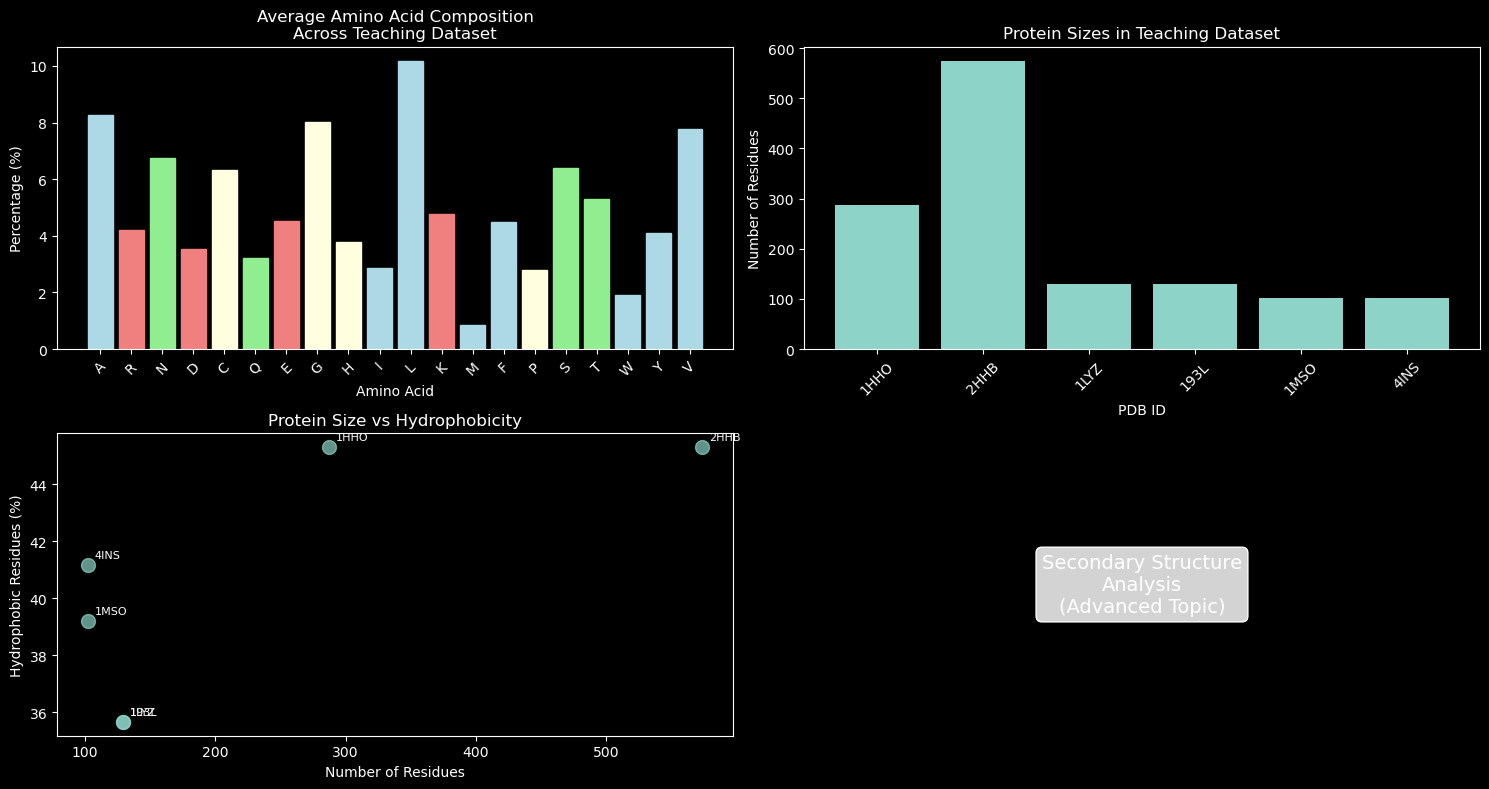

In [5]:

# =============================================================================
# SECTION 4: AMINO ACID COMPOSITION ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("SECTION 4: AMINO ACID COMPOSITION ANALYSIS")
print("="*60)

def analyze_amino_acid_composition(analysis_results):
    """Analyze amino acid composition across proteins"""
    
    # Standard amino acids
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
                   'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
    composition_data = []
    
    for result in analysis_results:
        if result['amino_acids']:
            aa_counts = {aa: result['amino_acids'].count(aa) for aa in amino_acids}
            total_aa = sum(aa_counts.values())
            
            if total_aa > 0:
                composition = {
                    'pdb_id': result['pdb_id'],
                    'total_residues': total_aa
                }
                for aa in amino_acids:
                    composition[f'{aa}_percent'] = (aa_counts[aa] / total_aa) * 100
                
                composition_data.append(composition)
    
    return pd.DataFrame(composition_data)

# Analyze amino acid composition
comp_df = analyze_amino_acid_composition(analysis_results)

if not comp_df.empty:
    # Plot amino acid composition
    plt.figure(figsize=(15, 8))
    
    # Get amino acid percentage columns
    aa_cols = [col for col in comp_df.columns if col.endswith('_percent')]
    aa_names = [col[:-8] for col in aa_cols]
    
    # Calculate mean composition across all proteins
    mean_composition = comp_df[aa_cols].mean()
    
    plt.subplot(2, 2, 1)
    bars = plt.bar(aa_names, mean_composition.values)
    plt.title('Average Amino Acid Composition\nAcross Teaching Dataset')
    plt.xlabel('Amino Acid')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    
    # Color bars by amino acid properties
    hydrophobic = ['A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V']
    polar = ['N', 'Q', 'S', 'T']
    charged = ['R', 'K', 'D', 'E']
    special = ['C', 'G', 'P', 'H']
    
    for i, aa in enumerate(aa_names):
        if aa in hydrophobic:
            bars[i].set_color('lightblue')
        elif aa in polar:
            bars[i].set_color('lightgreen')
        elif aa in charged:
            bars[i].set_color('lightcoral')
        else:
            bars[i].set_color('lightyellow')
    
    # Protein size comparison
    plt.subplot(2, 2, 2)
    plt.bar(comp_df['pdb_id'], comp_df['total_residues'])
    plt.title('Protein Sizes in Teaching Dataset')
    plt.xlabel('PDB ID')
    plt.ylabel('Number of Residues')
    plt.xticks(rotation=45)
    
    # Hydrophobicity analysis
    plt.subplot(2, 2, 3)
    hydrophobic_cols = [f'{aa}_percent' for aa in hydrophobic]
    hydrophobic_percent = comp_df[hydrophobic_cols].sum(axis=1)
    
    plt.scatter(comp_df['total_residues'], hydrophobic_percent, alpha=0.7, s=100)
    plt.title('Protein Size vs Hydrophobicity')
    plt.xlabel('Number of Residues')
    plt.ylabel('Hydrophobic Residues (%)')
    
    for i, pdb_id in enumerate(comp_df['pdb_id']):
        plt.annotate(pdb_id, (comp_df['total_residues'].iloc[i], hydrophobic_percent.iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Secondary structure prediction visualization placeholder
    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, 'Secondary Structure\nAnalysis\n(Advanced Topic)', 
             ha='center', va='center', transform=plt.gca().transAxes,
             fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [6]:

# =============================================================================
# SECTION 5: COMPARATIVE ANALYSIS EXERCISES
# =============================================================================

print("\n" + "="*60)
print("SECTION 5: STUDENT EXERCISES AND ASSIGNMENTS")
print("="*60)

def create_student_exercises():
    """Generate student exercises using the PDB dataset"""
    
    exercises = {
        "Beginner Level": [
            {
                "title": "Protein Size Investigation",
                "task": "Compare protein sizes across different organisms",
                "datasets": ["1HHO (human)", "1MBO (sperm whale)", "1LYZ (chicken)"],
                "questions": [
                    "Which protein has the most amino acids?",
                    "How does organism complexity relate to protein size?",
                    "What might explain size differences?"
                ]
            },
            {
                "title": "Visualization Mastery",
                "task": "Create different views of the same protein",
                "proteins": ["1LYZ"],
                "requirements": [
                    "Cartoon representation showing secondary structure",
                    "Surface view showing protein shape",
                    "Stick model of active site residues"
                ]
            }
        ],
        
        "Intermediate Level": [
            {
                "title": "Structure-Function Relationships",
                "task": "Compare oxygen-binding proteins",
                "proteins": ["1HHO (hemoglobin)", "1MBO (myoglobin)"],
                "analysis": [
                    "Identify heme groups in both structures",
                    "Compare quaternary structures",
                    "Relate structural differences to functional differences"
                ]
            },
            {
                "title": "Amino Acid Composition Analysis",
                "task": "Analyze chemical properties across protein families",
                "approach": "Statistical analysis of amino acid frequencies",
                "coding_required": True
            }
        ],
        
        "Advanced Level": [
            {
                "title": "Evolutionary Analysis",
                "task": "Compare homologous proteins across species",
                "proteins": ["Multiple lysozyme structures"],
                "methods": ["Structural alignment", "Conservation analysis"],
                "tools": ["BioPython", "PyMOL scripting"]
            },
            {
                "title": "Drug Design Project",
                "task": "Identify potential drug binding sites",
                "approach": "Cavity detection and analysis",
                "real_world_application": "Pharmaceutical research"
            }
        ]
    }
    
    return exercises

exercises = create_student_exercises()

print("🎓 STUDENT EXERCISE FRAMEWORK")
print("="*40)

for level, exercise_list in exercises.items():
    print(f"\n{level.upper()}:")
    for i, exercise in enumerate(exercise_list, 1):
        print(f"  {i}. {exercise['title']}")
        print(f"     Task: {exercise['task']}")
        if 'proteins' in exercise:
            print(f"     Proteins: {', '.join(exercise['proteins'])}")
        if 'coding_required' in exercise:
            print(f"     💻 Coding Required: Yes")



SECTION 5: STUDENT EXERCISES AND ASSIGNMENTS
🎓 STUDENT EXERCISE FRAMEWORK

BEGINNER LEVEL:
  1. Protein Size Investigation
     Task: Compare protein sizes across different organisms
  2. Visualization Mastery
     Task: Create different views of the same protein
     Proteins: 1LYZ

INTERMEDIATE LEVEL:
  1. Structure-Function Relationships
     Task: Compare oxygen-binding proteins
     Proteins: 1HHO (hemoglobin), 1MBO (myoglobin)
  2. Amino Acid Composition Analysis
     Task: Analyze chemical properties across protein families
     💻 Coding Required: Yes

ADVANCED LEVEL:
  1. Evolutionary Analysis
     Task: Compare homologous proteins across species
     Proteins: Multiple lysozyme structures
  2. Drug Design Project
     Task: Identify potential drug binding sites


In [7]:

# =============================================================================
# SECTION 6: ASSESSMENT AND LEARNING OUTCOMES
# =============================================================================

print("\n" + "="*60)
print("SECTION 6: LEARNING OUTCOMES & ASSESSMENT")
print("="*60)

learning_outcomes = {
    "Technical Skills": [
        "Database querying and API usage",
        "3D structure visualization",
        "Statistical analysis of biological data",
        "Python programming for bioinformatics",
        "Data interpretation and presentation"
    ],
    
    "Biological Concepts": [
        "Protein structure hierarchy (primary to quaternary)",
        "Structure-function relationships",
        "Evolutionary conservation",
        "Enzyme mechanisms and active sites",
        "Protein families and classification"
    ],
    
    "Scientific Thinking": [
        "Hypothesis formation and testing",
        "Critical evaluation of data",
        "Integration of multiple data sources",
        "Scientific communication",
        "Research methodology"
    ]
}

assessment_methods = {
    "Formative Assessment": [
        "Interactive notebook completion",
        "Peer review of visualizations",
        "Discussion forum participation",
        "Mini-quizzes on protein properties"
    ],
    
    "Summative Assessment": [
        "Research project: Novel protein analysis",
        "Group presentation: Protein family comparison",
        "Written report: Structure-function analysis",
        "Code portfolio: Analysis scripts"
    ]
}

print("🎯 LEARNING OUTCOMES:")
for category, outcomes in learning_outcomes.items():
    print(f"\n{category}:")
    for outcome in outcomes:
        print(f"  • {outcome}")

print(f"\n📋 ASSESSMENT METHODS:")
for category, methods in assessment_methods.items():
    print(f"\n{category}:")
    for method in methods:
        print(f"  • {method}")



SECTION 6: LEARNING OUTCOMES & ASSESSMENT
🎯 LEARNING OUTCOMES:

Technical Skills:
  • Database querying and API usage
  • 3D structure visualization
  • Statistical analysis of biological data
  • Python programming for bioinformatics
  • Data interpretation and presentation

Biological Concepts:
  • Protein structure hierarchy (primary to quaternary)
  • Structure-function relationships
  • Evolutionary conservation
  • Enzyme mechanisms and active sites
  • Protein families and classification

Scientific Thinking:
  • Hypothesis formation and testing
  • Critical evaluation of data
  • Integration of multiple data sources
  • Scientific communication
  • Research methodology

📋 ASSESSMENT METHODS:

Formative Assessment:
  • Interactive notebook completion
  • Peer review of visualizations
  • Discussion forum participation
  • Mini-quizzes on protein properties

Summative Assessment:
  • Research project: Novel protein analysis
  • Group presentation: Protein family comparison
  • W

In [9]:

# =============================================================================
# SECTION 7: RESOURCES AND NEXT STEPS
# =============================================================================

print("\n" + "="*60)
print("SECTION 7: RESOURCES AND NEXT STEPS")
print("="*60)

resources = {
    "Essential Tools": [
        "py3Dmol: Interactive 3D visualization",
        "BioPython: Python tools for bioinformatics",
        "pandas: Data analysis and manipulation",
        "matplotlib/seaborn: Data visualization",
        "Jupyter notebooks: Interactive development"
    ],
    
    "Advanced Tools": [
        "PyMOL: Professional molecular visualization",
        "ChimeraX: Advanced structural analysis",
        "VMD: Molecular dynamics visualization",
        "Biotite: High-performance structural biology",
        "MDAnalysis: Trajectory analysis"
    ],
    
    "Databases": [
        "RCSB PDB: Protein structures",
        "UniProt: Protein sequences and annotations",
        "Pfam: Protein families",
        "SCOP: Structural classification",
        "CATH: Protein structure classification"
    ],
    
    "Learning Resources": [
        "PDB-101: Educational materials from RCSB",
        "PyMOL Wiki: Tutorials and scripts",
        "BioPython Tutorial: Comprehensive guide",
        "Coursera/edX: Bioinformatics courses",
        "Nature Structural Biology: Research articles"
    ]
}

print("📚 RECOMMENDED RESOURCES:")
for category, items in resources.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print("\n" + "="*60)
print("🎉 CONGRATULATIONS!")
print("You've completed the PDB protein structure analysis tutorial!")
print("This notebook provides a foundation for teaching molecular biology")
print("through hands-on data science approaches.")
print("="*60)

# Final interactive example
print("\n🔬 Try this: Modify the code above to explore your own protein of interest!")
print("Simply replace PDB IDs in the teaching_proteins dictionary.")

# Create a simple interactive widget concept
def explore_protein(pdb_id):
    """Template function for students to explore any protein"""
    print(f"🧬 Exploring protein: {pdb_id}")
    
    # Download and analyze
    analysis, structure = download_and_analyze_structure(pdb_id)
    
    if analysis:
        print(f"📊 Basic Properties:")
        print(f"  Chains: {analysis['num_chains']}")
        print(f"  Residues: {analysis['num_residues']}")
        print(f"  Atoms: {analysis['num_atoms']}")
        
        # Create viewer
        print(f"\n🔍 3D Structure:")
        viewer = create_protein_viewer(pdb_id)
        display(viewer)
        
        return analysis
    else:
        print("❌ Could not retrieve protein data")
        return None

# Example usage (uncomment to try):
# explore_protein('1BRD')  # DNA-binding protein

print("\n💡 Next Steps for Instructors:")
print("1. Customize the teaching_proteins dictionary for your course")
print("2. Add specific exercises relevant to your learning objectives") 
print("3. Integrate with your LMS for student submissions")
print("4. Develop rubrics for assessment")
print("5. Create video tutorials for complex concepts")



SECTION 7: RESOURCES AND NEXT STEPS
📚 RECOMMENDED RESOURCES:

Essential Tools:
  • py3Dmol: Interactive 3D visualization
  • BioPython: Python tools for bioinformatics
  • pandas: Data analysis and manipulation
  • matplotlib/seaborn: Data visualization
  • Jupyter notebooks: Interactive development

Advanced Tools:
  • PyMOL: Professional molecular visualization
  • ChimeraX: Advanced structural analysis
  • VMD: Molecular dynamics visualization
  • Biotite: High-performance structural biology
  • MDAnalysis: Trajectory analysis

Databases:
  • RCSB PDB: Protein structures
  • UniProt: Protein sequences and annotations
  • Pfam: Protein families
  • SCOP: Structural classification
  • CATH: Protein structure classification

Learning Resources:
  • PDB-101: Educational materials from RCSB
  • PyMOL Wiki: Tutorials and scripts
  • BioPython Tutorial: Comprehensive guide
  • Coursera/edX: Bioinformatics courses
  • Nature Structural Biology: Research articles

🎉 CONGRATULATIONS!
You've 